<a href="https://colab.research.google.com/github/ariG23498/SimCLR_PseudoLabel/blob/master/CIFAR10/Full_Linear_Evaluation_PseudoLabels_SimCLR_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# TensorFlow Imports
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
!nvidia-smi

Fri Aug 21 08:22:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!wget https://raw.githubusercontent.com/GoogleCloudPlatform/keras-idiomatic-programmer/master/zoo/resnet/resnet_cifar10.py

--2020-08-21 08:22:31--  https://raw.githubusercontent.com/GoogleCloudPlatform/keras-idiomatic-programmer/master/zoo/resnet/resnet_cifar10.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6064 (5.9K) [text/plain]
Saving to: ‘resnet_cifar10.py’

resnet_cifar10.py   100%[===================>]   5.92K  --.-KB/s    in 0s      

2020-08-21 08:22:31 (78.0 MB/s) - ‘resnet_cifar10.py’ saved [6064/6064]



In [4]:
!wget https://storage.googleapis.com/resnet-simclr-pseudo-labels/autoenc_resnet_simclr_cifar10.h5

--2020-08-21 08:22:40--  https://storage.googleapis.com/resnet-simclr-pseudo-labels/autoenc_resnet_simclr_cifar10.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.120.128, 74.125.133.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085560 (4.8M) [application/octet-stream]
Saving to: ‘autoenc_resnet_simclr_cifar10.h5’

autoenc_resnet_simc 100%[===================>]   4.85M  17.3MB/s    in 0.3s    

2020-08-21 08:22:41 (17.3 MB/s) - ‘autoenc_resnet_simclr_cifar10.h5’ saved [5085560/5085560]



In [5]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
import tensorflow as tf
import seaborn as sns
import numpy as np
import resnet_cifar10
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
# Load the full set of CIFAR10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Prepare the dataset
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

170500096/170498071 [==============================] - 6s 0us/step


In [7]:
# ResNetCIFAR10
n = 4
depth =  n * 9 + 2
n_blocks = ((depth - 2) // 9) - 1

# The input tensor
inputs = Input(shape=(32, 32, 3))

# The Stem Convolution Group
x = resnet_cifar10.stem(inputs)
   
# The learner
outputs = resnet_cifar10.learner(x, n_blocks)

# Instantiate the Model
resnet_headless_model = Model(inputs, outputs)

In [8]:
# Architecture utils
def get_resnet_simclr_deeper(hidden_1, hidden_2, hidden_3):
    inputs = Input((32, 32, 3))
    h = resnet_headless_model(inputs, training=False)
    h = GlobalAveragePooling2D()(h)
    
    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [10]:
resnet_simclr = get_resnet_simclr_deeper(256, 128, 50)
resnet_simclr.load_weights("autoenc_resnet_simclr_cifar10.h5")
resnet_simclr.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
functional_3 (Functional)    (None, 8, 8, 256)         1121344   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_3 (Activation)    (None, 128)              

In [11]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [12]:
def get_linear_model(features):
    model = Sequential([
        Dense(10, input_shape=(features, ), activation="softmax")
    ])
    
    return model

## Evaluation

In [13]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

In [14]:
# These layers won't be trained during linear evaluation
resnet_simclr.layers[1].trainable = False
resnet_simclr.layers[3].trainable = False
resnet_simclr.layers[5].trainable = False

# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)
print(projection.summary())

# Extract train and test features
train_features = projection.predict(x_train)
test_features = projection.predict(x_test)

print(train_features.shape, test_features.shape)

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
functional_3 (Functional)    (None, 8, 8, 256)         1121344   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_3 (Activation)    (None, 128)              

Epoch 1/100
782/782 [==============================] - 2s 3ms/step - loss: 1.9641 - accuracy: 0.2870 - val_loss: 1.8084 - val_accuracy: 0.3457
Epoch 2/100
782/782 [==============================] - 2s 3ms/step - loss: 1.7881 - accuracy: 0.3508 - val_loss: 1.7607 - val_accuracy: 0.3643
Epoch 3/100
782/782 [==============================] - 2s 3ms/step - loss: 1.7567 - accuracy: 0.3645 - val_loss: 1.7408 - val_accuracy: 0.3712
Epoch 4/100
782/782 [==============================] - 2s 3ms/step - loss: 1.7417 - accuracy: 0.3676 - val_loss: 1.7318 - val_accuracy: 0.3720
Epoch 5/100
782/782 [==============================] - 2s 3ms/step - loss: 1.7329 - accuracy: 0.3737 - val_loss: 1.7247 - val_accuracy: 0.3784
Epoch 6/100
782/782 [==============================] - 2s 3ms/step - loss: 1.7267 - accuracy: 0.3763 - val_loss: 1.7228 - val_accuracy: 0.3777
Epoch 7/100
782/782 [==============================] - 2s 3ms/step - loss: 1.7227 - accuracy: 0.3781 - val_loss: 1.7182 - val_accuracy: 0.3786

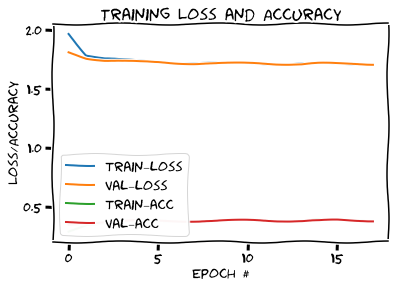

In [15]:
# Linear model
linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train,
                 validation_data=(test_features, y_test),
                 batch_size=64,
                 epochs=100,
                 callbacks=[es])
plot_training(history)

In [16]:
# Encoder model with lesser non-linearity
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)
print(projection.summary())

# Extract train and test features
train_features = projection.predict(x_train)
test_features = projection.predict(x_test)

print(train_features.shape, test_features.shape)

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
functional_3 (Functional)    (None, 8, 8, 256)         1121344   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
Total params: 1,187,136
Trainable params: 0
Non-trainable params: 1,187,136
_________________________________________________________________
None
(50000, 256) (10000, 256)


Epoch 1/100
782/782 [==============================] - 2s 3ms/step - loss: 1.8907 - accuracy: 0.3160 - val_loss: 1.7478 - val_accuracy: 0.3681
Epoch 2/100
782/782 [==============================] - 2s 3ms/step - loss: 1.7310 - accuracy: 0.3678 - val_loss: 1.6968 - val_accuracy: 0.3861
Epoch 3/100
782/782 [==============================] - 2s 3ms/step - loss: 1.6990 - accuracy: 0.3814 - val_loss: 1.6806 - val_accuracy: 0.3888
Epoch 4/100
782/782 [==============================] - 2s 3ms/step - loss: 1.6820 - accuracy: 0.3860 - val_loss: 1.6680 - val_accuracy: 0.3961
Epoch 5/100
782/782 [==============================] - 2s 3ms/step - loss: 1.6715 - accuracy: 0.3916 - val_loss: 1.6584 - val_accuracy: 0.3946
Epoch 6/100
782/782 [==============================] - 2s 3ms/step - loss: 1.6626 - accuracy: 0.3936 - val_loss: 1.6606 - val_accuracy: 0.4023
Epoch 7/100
782/782 [==============================] - 2s 3ms/step - loss: 1.6564 - accuracy: 0.3965 - val_loss: 1.6471 - val_accuracy: 0.4047

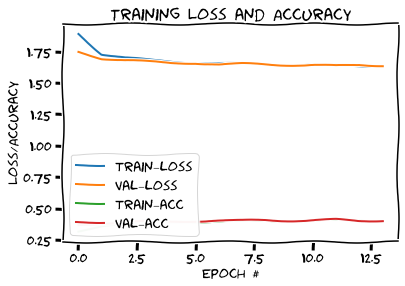

In [17]:
# Linear model
linear_model = get_linear_model(256)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train,
                 validation_data=(test_features, y_test),
                 batch_size=64,
                 epochs=100,
                 callbacks=[es])
plot_training(history)

In [18]:
# Encoder model with no projection
projection = Model(resnet_simclr.input, resnet_simclr.layers[-6].output)
print(projection.summary())

# Extract train and test features
train_features = projection.predict(x_train)
test_features = projection.predict(x_test)

print(train_features.shape, test_features.shape)

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
functional_3 (Functional)    (None, 8, 8, 256)         1121344   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 256)               0         
Total params: 1,121,344
Trainable params: 0
Non-trainable params: 1,121,344
_________________________________________________________________
None
(50000, 256) (10000, 256)


Epoch 1/100
782/782 [==============================] - 2s 3ms/step - loss: 1.9952 - accuracy: 0.3010 - val_loss: 1.8051 - val_accuracy: 0.3348
Epoch 2/100
782/782 [==============================] - 2s 3ms/step - loss: 1.7785 - accuracy: 0.3506 - val_loss: 1.7570 - val_accuracy: 0.3577
Epoch 3/100
782/782 [==============================] - 2s 3ms/step - loss: 1.7432 - accuracy: 0.3661 - val_loss: 1.7149 - val_accuracy: 0.3805
Epoch 4/100
782/782 [==============================] - 2s 3ms/step - loss: 1.7199 - accuracy: 0.3781 - val_loss: 1.7082 - val_accuracy: 0.3718
Epoch 5/100
782/782 [==============================] - 2s 3ms/step - loss: 1.6955 - accuracy: 0.3835 - val_loss: 1.7035 - val_accuracy: 0.3782
Epoch 6/100
782/782 [==============================] - 2s 3ms/step - loss: 1.6874 - accuracy: 0.3874 - val_loss: 1.6926 - val_accuracy: 0.3820
Epoch 7/100
782/782 [==============================] - 2s 3ms/step - loss: 1.6718 - accuracy: 0.3930 - val_loss: 1.6461 - val_accuracy: 0.4050

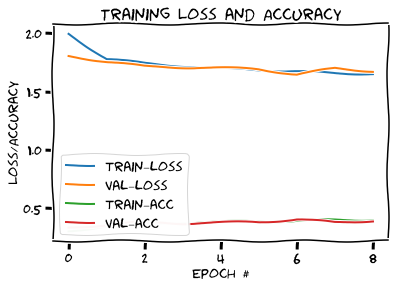

In [19]:
# Linear model
linear_model = get_linear_model(256)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train,
                 validation_data=(test_features, y_test),
                 batch_size=64,
                 epochs=100,
                 callbacks=[es])
plot_training(history)